In [1]:
# Load certain useful packages in python
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cycler import cycler

In [2]:
# Specify the location of the files for cobalt and ocean variables
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
name_cobalt = 'ocean_cobalt_omip_tracers_month_z'
name_mom6 = 'ocean_monthly_z'
ext = '/av/monthly_5yr/'
time = '.0941-0945.*'
path_cobalt = rootdir+name_cobalt+ext+name_cobalt+time+'.nc'
path_mom6 = rootdir+name_mom6+ext+name_mom6+time+'.nc'

In [3]:
ds_cobalt = xr.open_mfdataset(path_cobalt)
ds_mom6 = xr.open_mfdataset(path_mom6)

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
ds = xr.merge([ds_mom6.thetao, ds_mom6.volcello, ds_cobalt.phyc, ds_cobalt.pp])

In [5]:
def weightedsum(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedsum = variable_times_weights.sum()
    return weightedsum

def weightedmean(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    return weightedmean

def weightedstd(ds,variable,weights):
    # variable and weights are strings
    M = ds[variable].size
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    numerator = ds[weights]*(ds[variable]-weightedmean)**2
    numerator = numerator.sum()
    denominator = ((M-1)/M)*ds[weights].sum()
    weightedstd = numerator/denominator
    return weightedstd

In [8]:
%%time
ds = ds.set_coords('thetao')
theta_bins = np.arange(-2,32,2) # Specify the range of the bins
theta_bin_labels =np.arange(-1,31,2)
times = np.arange(0,1,1)
# Pre-allocate numpy arrays of the correct size
### Should redo these as DataArrays ###
phyc_in_theta_weightedsum = np.zeros((times.size,theta_bins.size-1))
pp_in_theta_weightedsum = np.zeros((times.size,theta_bins.size-1))
volcello_in_theta_sum = np.zeros((times.size,theta_bins.size-1))
for t in times:
    # Do grouping
    ds_in_theta = ds.isel(time=t).groupby_bins('thetao',theta_bins,labels=theta_bin_labels)
    # Perform calculations
    phyc_in_theta_weightedsum[t,:] = ds_in_theta.apply(weightedsum,variable='phyc',weights='volcello').values
    pp_in_theta_weightedsum[t,:] = ds_in_theta.apply(weightedmean,variable='pp',weights='volcello').values
    volcello_in_theta_sum[t,:] = ds_in_theta.sum(xr.ALL_DIMS).volcello.values

CPU times: user 1min 2s, sys: 7.44 s, total: 1min 9s
Wall time: 1min 9s


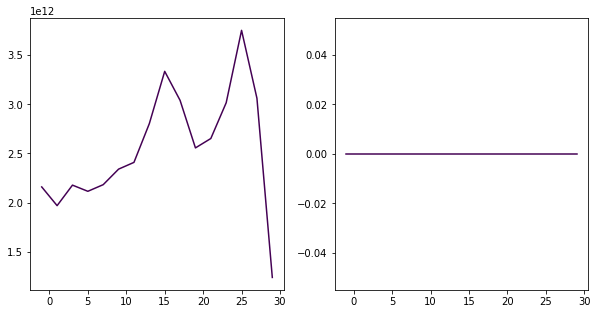

In [9]:
colors = plt.cm.viridis(np.linspace(0,1,12))
default_cycler = cycler(color=colors)
plt.rc('axes',prop_cycle = default_cycler)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
ax[0].plot(theta_bin_labels,phyc_in_theta_weightedsum.transpose());
ax[1].plot(theta_bin_labels,pp_in_theta_weightedmean.transpose());

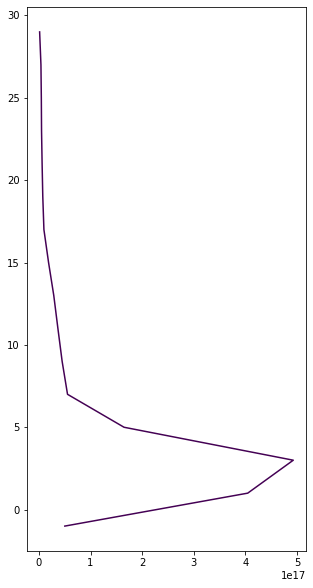

In [11]:
fig,ax = plt.subplots(figsize = (5,10))
ax.plot(volcello_in_theta_sum.transpose(),theta_bin_labels);